In [37]:
import pandas as pd

import numpy as np
from numpy import mean
from numpy import std

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load Train and Test Texts (Preprocessed)

In [14]:
train_df = pd.read_excel('corpus/train.xlsx', usecols = [1,2,3])
test_df = pd.read_excel('corpus/test.xlsx', usecols = [1,2,3])

# Load and Process Glossaries

### Load glossaries and assign their class

In [17]:
sport_df = pd.read_excel('glossary/deportes.xlsx', names = ['Word', 'Rank'] , usecols = [0,1])
sport_df['Class'] = 0

health_df = pd.read_excel('glossary/salud.xlsx', names = ['Word', 'Rank'] , usecols = [0,1])
health_df['Class'] = 1

politics_df = pd.read_excel('glossary/politica.xlsx', names = ['Word', 'Rank'] , usecols = [0,1])
politics_df['Class'] = 2

### Glossaries sizes

In [18]:
print('Sports Glossary Size:', len(sport_df))
print('Health Glossary Size:', len(health_df))
print('Politics Glossary Size:', len(politics_df))

print('Total Glossary Size:', (len(politics_df) + len(health_df) + len(sport_df)))

Sports Glossary Size: 5954
Health Glossary Size: 4940
Politics Glossary Size: 6485
Total Glossary Size: 17379


### Delete duplicated words in the glossaries

In [19]:
glossary_df = pd.concat([sport_df, health_df, politics_df])
glossary_df = glossary_df.drop_duplicates(subset = 'Word', keep = False)
glossary_df.reset_index(drop = True, inplace = True)

### Processed glossaries sizes

In [20]:
print('Sports Glossary Size:', len(glossary_df[glossary_df['Class'] == 0]))
print('Health Glossary Size:', len(glossary_df[glossary_df['Class'] == 1]))
print('Politics Glossary Size:', len(glossary_df[glossary_df['Class'] == 2]))

print('Total Glossary Size:', len(glossary_df))

Sports Glossary Size: 4608
Health Glossary Size: 3588
Politics Glossary Size: 4878
Total Glossary Size: 13074


### Processed glossaries's 100 best ranked words

In [21]:
dep = glossary_df[glossary_df['Class'] == 0][:100]

dep.to_excel('glossary/Processed_Sports.xlsx', index = False)

dep

,Word,Rank,Class
0,equipos,0.733358,0
1,juegos,0.648982,0
2,arco,0.513216,0
3,tiro,0.476139,0
4,federación,0.452926,0
...,...,...,...
95,par,0.180682,0
96,ángela,0.178913,0
97,martínez,0.178189,0
98,atletas,0.178130,0


In [22]:
hth =glossary_df[glossary_df['Class'] == 1][:100]

hth.to_excel('glossary/Processed_Health.xlsx', index = False)

hth

,Word,Rank,Class
4608,dolor,0.599021,1
4609,plomo,0.551113,1
4610,enfermedades,0.538785,1
4611,mental,0.473210,1
4612,virus,0.459235,1
...,...,...,...
4703,azoospermia,0.149694,1
4704,compatible,0.148139,1
4705,campoy,0.148139,1
4706,dolencias,0.147137,1


In [24]:
pol = glossary_df[glossary_df['Class'] == 2][:100]

pol.to_excel('glossary/Processed_Politics.xlsx', index = False)

pol

,Word,Rank,Class
8196,ley,0.893592,2
8197,pp,0.890320,2
8198,igualdad,0.695077,2
8199,psoe,0.647693,2
8200,becas,0.511423,2
...,...,...,...
8291,militares,0.191283,2
8292,responde,0.189121,2
8293,carmen calvo,0.188672,2
8294,calvo,0.188672,2


### Unify each glossary's 100 best ranked words in one common glossary

In [25]:
list_df = [glossary_df[glossary_df['Class'] == 0][:100], glossary_df[glossary_df['Class'] == 1][:100], glossary_df[glossary_df['Class'] == 2][:100]]

glossary_df = pd.concat(list_df, ignore_index = True)

# Obtain TF-IDF Matrices

### Obtain vocabulary from glossary and initialize the vectorizer with it

In [26]:
myvocabulary = list(glossary_df['Word'])

vectorizer = TfidfVectorizer(vocabulary = myvocabulary, ngram_range = (1,3))

### Obtain tf-idf vectors from all training texts

In [27]:
train_vec = vectorizer.fit_transform(train_df.iloc[:,0])
train_vec = train_vec.todense()

In [28]:
train_vec_df = pd.DataFrame(train_vec)
train_vec_df.columns = myvocabulary

train_label_df = train_df.iloc[:,1]

### Obtain tf-idf vectors from all test texts

In [29]:
test_vec = vectorizer.transform(test_df.iloc[:,0])
test_vec = test_vec.todense()

In [31]:
test_vec_df = pd.DataFrame(test_vec)
test_vec_df.columns = myvocabulary

test_label_df = test_df.iloc[:,1]

### Obtain train and test data

In [32]:
x_train = train_vec_df.values
y_train = train_label_df.values

x_test = test_vec_df.values
y_test = test_label_df.values

# Train Model (SVC)

In [33]:
model = svm.SVC(kernel = 'linear', C = 1, gamma = 'scale', probability = True)

model.fit(x_train, y_train)

SVC(C=1, kernel='linear', probability=True)

## Probabilistic Prediction

In [34]:
p_prediction = model.predict_proba(x_test)

## Non Probabilistic Prediction

In [35]:
np_prediction = model.predict(x_test)

# Results

### Create dataset with prediction results

In [68]:
prediction = [np.round(x,3) for x in p_prediction]

prediction_df = pd.DataFrame(p_prediction)
prediction_df.columns=['Sports', 'Health', 'Politics']

prediction_df['document'] = test_df.iloc[:,0]
prediction_df['class'] = y_test
prediction_df['name'] = test_df.iloc[:,2]
prediction_df['predicted_class'] = np_prediction
prediction_df['probability'] = prediction_df[['Sports', 'Health', 'Politics']].max(axis=1)

prediction_df[prediction_df['class'] != prediction_df['predicted_class']]

,Sports,Health,Politics,document,class,name,predicted_class,probability
2,0.005,0.992,0.003,cuba anunció retirada doctores brasil acusar p...,2,Politica_49.txt,1,0.992
5,0.263,0.623,0.114,conseller sanidad salud pública miguel mínguez...,2,Politica_19.txt,1,0.623
38,0.016,0.888,0.096,ministerio sanidad política social decidido de...,2,Politica_18.txt,1,0.888
44,0.437,0.119,0.444,discusión eterna baloncesto grande tiempos pel...,0,Deportes_36.txt,2,0.444


In [69]:
p_prediction_df = p_prediction_df.drop(['Sports', 'Health', 'Politics'], axis=1)

p_prediction_df.to_excel('corpus/test_results.xlsx', index = False)

### Create dataset with non probabilistic prediction metrics

In [62]:
metrics = classification_report(y_test, np_prediction, digits = 3, output_dict = True)

metrics_df = pd.DataFrame(metrics).transpose()

metrics_df

,precision,recall,f1-score,support
0,1.000000,0.966667,0.983051,30.000000
1,0.909091,1.000000,0.952381,30.000000
2,0.964286,0.900000,0.931034,30.000000
accuracy,0.955556,0.955556,0.955556,0.955556
macro avg,0.957792,0.955556,0.955489,90.000000
weighted avg,0.957792,0.955556,0.955489,90.000000


### Create confusion matrix with non probabilistic prediction metrics

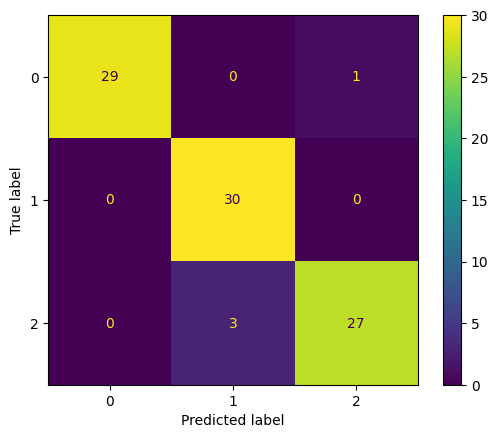

In [63]:
cm = confusion_matrix(y_test, np_prediction, labels=model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

disp.plot()
plt.show()